# Kili Tutorial: Importing medical data into a frame project 

In this tutorial, we will show you how to import dicom data into a [Frame Kili project](https://cloud.kili-technology.com/docs/video-interfaces/multi-frames-classification/#docsNav). Such projects allow you to annotate volumes of image data.

The data we use comes from [The Cancer Genome Atlas Lung Adenocarcinoma (TCGA-LUAD) data collection](https://wiki.cancerimagingarchive.net/display/Public/TCGA-LUAD). We selected 3 scans out of this dataset.

## Downloading data

Let's first import the scans. We host these files in a .zip on GDrive.

In [1]:
import os
import subprocess

import tqdm

In [2]:
os.makedirs(os.path.expanduser('~/Downloads'), exist_ok=True)

We will use a small package to help downloading the file hosted on Google Drive

In [3]:
%%bash
git clone https://github.com/chentinghao/download_google_drive.git
cd download_google_drive/
python download_gdrive.py 1q3qswXthFh3xMtAAnePph6vav3N7UtOF ~/Downloads/dicom_files.zip

Clonage dans 'download_google_drive'...
216MB [00:05, 38.7MB/s]


In [4]:
!apt-get install unzip

/bin/sh: apt-get: command not found


In [5]:
!unzip ~/Downloads/dicom_files.zip -d ~/Downloads/ > /dev/null

## Reading data

We can then read the dicom files with [pydicom](https://pydicom.github.io/pydicom/stable/).

In [6]:
ASSET_ROOT = os.path.expanduser('~/Downloads/TCGA-LUAD')

sorted_files = {}
asset_number = 0
for root, dirs, files in os.walk(ASSET_ROOT):
    if len(files) > 0:
        file_paths = list(map(lambda path: os.path.join(root, path), files))
        sorted_files[f'asset-{asset_number+1}'] = sorted(file_paths,
            key=lambda path: int(path.split('/')[-1].split('-')[1].split('.')[0]))
        asset_number += 1

Let's see what is inside the dataset :

asset-1


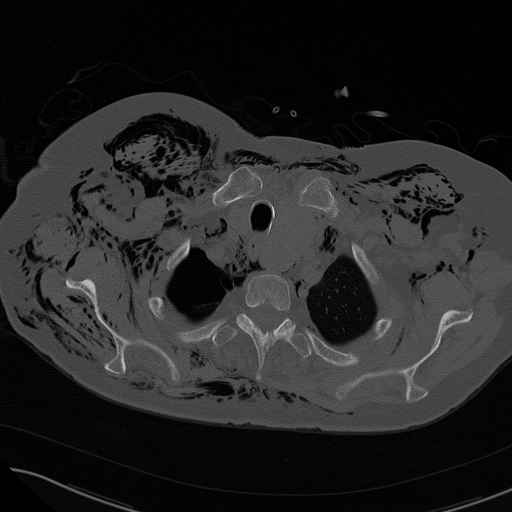

asset-2


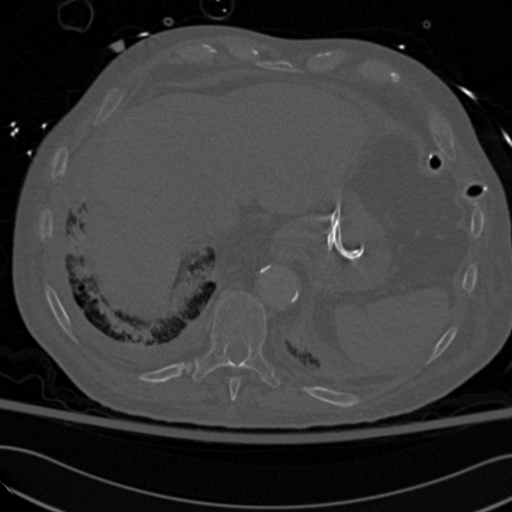

asset-3


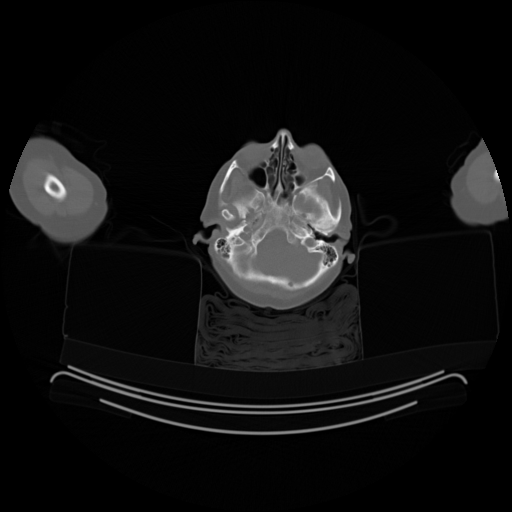

In [7]:
!pip install pillow
!pip install pydicom
from PIL import Image
import pydicom

def read_dcm_image(path):
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    # Currently, Kili does not support windowing in the application.
    # This will soon change, but until then we advise you to reduce the range to 256 values.
    image = (image - image.min()) / (image.max() - image.min()) * 256
    return Image.fromarray(image).convert('RGB')

for asset_key in sorted_files.keys():
    print(asset_key)
    im = read_dcm_image(sorted_files[asset_key][20])
    display(im)

## Extracting and serving images

For each of the dicom `.dcm` files, let's extract its content (image) and save it into a `.jpeg` image.

In [8]:
sorted_images = {}
for asset_key, files in sorted_files.items():
    images = []
    for file in tqdm.tqdm(files):
        im = read_dcm_image(file)
        im_file = file.replace('.dcm', '.jpeg')
        im.save(im_file, format='JPEG')
        images.append(im_file)
    sorted_images[asset_key] = images

100%|██████████| 329/329 [00:04<00:00, 77.39it/s]


We now have extracted jpeg images processable by Kili.

## Creating the project

We can now import those assets into a FRAME project !

Let's begin by creating a project

In [9]:
## You can also directly create the interface on the application.
interface = {
	"jobRendererWidth": 0.17,
	"jobs": {
		"JOB_0": {
			"mlTask": "OBJECT_DETECTION",
			"tools": [
				"semantic"
			],
			"instruction": "Segment the right class",
			"required": 1,
			"isChild": False,
			"content": {
				"categories": {
					"BONE": {
						"name": "Bone",
						"children": [],
						"color": "#0755FF"
					},
					"LUNG": {
						"name": "Lung",
						"children": [],
						"color": "#EEBA00"
					},
					"TISSUE_0": {
						"name": "Tissue",
						"children": [],
						"color": "#941100"
					}
				},
				"input": "radio"
			}
		}
	}
}

In [10]:
## Authentication
from kili.authentication import KiliAuth
from kili.playground import Playground

api_key = os.getenv('KILI_USER_API_KEY')
api_endpoint = os.getenv('KILI_API_ENDPOINT') # If you use Kili SaaS, use the url 'https://cloud.kili-technology.com/api/label/v2/graphql'
kauth = KiliAuth(api_key=api_key, api_endpoint=api_endpoint)
playground = Playground(kauth)

## Project creation
project = playground.create_project(
    description='Demo FRAME project',
    input_type='FRAME',
    json_interface=interface,
    title='Lungs from TCGA-LUAD'
)
project_id = project['id']

## Importing images

Finally, let's import the volumes using `appendManyToDataset` (see [link](https://staging.cloud.kili-technology.com/docs/python-graphql-api/python-api/#append_many_to_dataset)). The key argument is `json_content_array`, which is a list of list of strings. Each element is the list of urls or paths pointing to images of the volume considered.
 - Let's host these images locally to demonstrate how we would do it with cloud URLs for example :

In [11]:
subprocess.Popen(f'python -m http.server 8001 --directory {ASSET_ROOT}',
                 shell=True, stdin=None, stdout=None, stderr=None, close_fds=True)
ROOT_URL = 'http://localhost:8001/'

In [12]:
def files_to_urls(files):
    return list(map(lambda file: ROOT_URL + file.split('TCGA-LUAD')[1], files))

In [13]:
playground.append_many_to_dataset(
    project_id=project_id,
    external_id_array=list(sorted_images.keys()),
    json_content_array=list(map(files_to_urls, sorted_images.values()))
)

{'id': 'ckn8zc1e40jl50k1x99dkdgcd'}

Or, as mentionned, you can simply provide the paths to your images, and call the function like below : 

In [14]:
playground.append_many_to_dataset(
    project_id=project_id,
    external_id_array=list(map(lambda key: f'local-path-{key}',sorted_images.keys())),
    json_content_array=list(sorted_images.values())
)

{'id': 'ckn8zc1e40jl50k1x99dkdgcd'}

## Back to the interface

We can see our assets were imported...

In [15]:
ds_size = playground.count_assets(project_id=project_id)
print(ds_size)
assert ds_size == 6

6


![assets_inserted](img/assets_inserted.png)

...we can now annotate those assets !

![frame_annotation](img/frame_annotation.png)